In [2]:
import os
import sys
new_path = '/home/cc/stylegan_K1/'
sys.path.append(new_path)
import tensorflow
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config
import io
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve

In [3]:
'''Loading Pre trained network'''
tflib.init_tf()
#f = open('Data/Zips/karras2019stylegan-ffhq-1024x1024.pkl','rb')
f = open('/home/cc/network-snapshot-008040.pkl', 'rb')
_G, _D, Gs = pickle.load(f)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
#Gs.print_layers()

In [29]:
img_rows = 512
img_cols = 512
channels = 3 # I am using channel last models
img_shape = (channels, img_rows, img_cols)
latent_dim = 512
batch_size=128
Ngpus = 1
inputTrain = '/home/cc/Data/Images'
Imsize=(img_cols,img_cols)

data_pd = pd.read_pickle('/home/cc/Data/Zips/cm_index_df_fixed.p')
data_pd['FilePath']= data_pd.FilePath.apply(lambda x: os.path.join('/home/cc/Data/Images',x))
data_live = data_pd[data_pd.live_spoof == 1] # only live samples
data_live['Collection'] = data_live.CaptureID.apply(lambda x: x[0:3])
resize_df = data_live[data_live.Collection =='Pre']
resize_df.shape
resize_df.live_spoof=resize_df.live_spoof.astype(str)


datagen=ImageDataGenerator(data_format ="channels_first") # we rescale to -1 to 1 for our tanhs 
image_generator= datagen.flow_from_dataframe(
            directory= inputTrain,
            dataframe = resize_df,
            x_col = 'FilePath',
            y_col ='live_spoof',
            color_mode='rgb',
            target_size=(img_rows,img_cols),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False,
            )

/home/cc/anaconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/cc/anaconda3/envs/TF1/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Found 49001 validated image filenames.


In [30]:
image_generator.total_batches_seen

0

In [31]:
image_generator.batch_index

0

In [32]:
len(image_generator.filenames)

49001

In [ ]:
pred = np.zeros((len(image_generator.filenames),1), dtype=np.float32)
for i in range(len(image_generator)-1):
    #print(i)
    images = image_generator.next()
    pred[(i)*batch_size:(i+1)*batch_size] = _D.run(images, None)
    #pred.append(_D.run(images, None))
    #sess = _D.get_output_for(images, None, return_as_list=True)

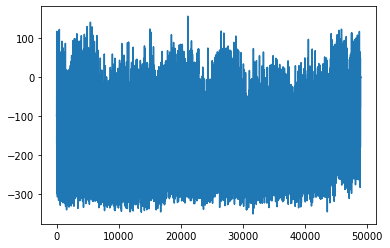

In [41]:
plt.plot(pred)

In [59]:
last = image_generator.next()

In [61]:
last.shape

(105, 3, 512, 512)

In [65]:
fix = np.zeros((128,3,512,512), dtype=np.float32)
fix[0:105,:,:,:] = last

In [66]:
last_pr = _D.run(fix, None)

In [78]:
pred[(i+1)*128:] =last_pr[0:105]

In [80]:
resize_df['predict'] = pred

/home/cc/anaconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [82]:
resize_df.to_pickle('/home/cc/Data/Stylegan_Spoof.p')

(array([1.4770e+03, 8.3340e+03, 1.1352e+04, 1.0446e+04, 8.1290e+03,
        5.4560e+03, 2.6840e+03, 9.5700e+02, 1.5800e+02, 8.0000e+00]),
 array([-350.72894 , -297.62448 , -244.52005 , -191.41559 , -138.31114 ,
         -85.206696,  -32.102245,   21.002203,   74.10665 ,  127.211105,
         180.31555 ], dtype=float32),
 <a list of 10 Patch objects>)

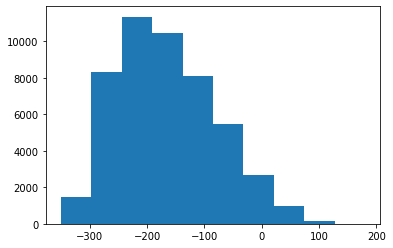

In [83]:
plt.hist(resize_df.predict)

In [108]:
data_pd = pd.read_pickle('/home/cc/Data/Zips/cm_index_df_fixed.p')
data_pd['FilePath']= data_pd.FilePath.apply(lambda x: os.path.join('/home/cc/Data/Images',x))
data_live = data_pd[data_pd.live_spoof == 0] # only live samples
data_live['Collection'] = data_live.CaptureID.apply(lambda x: x[0:3])
live_df = data_live[data_live.Collection =='Pre']
live_df.shape
live_df.live_spoof=resize_df.live_spoof.astype(str)
unique_subjects = sorted(live_df.SubjectID.unique())

/home/cc/anaconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/cc/anaconda3/envs/TF1/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [112]:
'''Selecting 250 subjects, we used the 0-250 for training so there is no overlap'''
live_subject = unique_subjects[250:500]

In [113]:
live_Test_df = pd.DataFrame()
for subject in live_subject:
    sub_df = live_df[live_df.SubjectID== subject]
    live_Test_df = pd.concat([live_Test_df,sub_df])

In [114]:
live_Test_df.shape

(63530, 21)

In [115]:
img_rows = 512
img_cols = 512
channels = 3 # I am using channel last models
img_shape = (channels, img_rows, img_cols)
latent_dim = 512
batch_size=128
Ngpus = 1
inputTrain = '/home/cc/Data/Images'
Imsize=(img_cols,img_cols)

datagen=ImageDataGenerator(data_format ="channels_first") # we rescale to -1 to 1 for our tanhs 
image_generator= datagen.flow_from_dataframe(
            directory= inputTrain,
            dataframe = live_Test_df,
            x_col = 'FilePath',
            y_col ='live_spoof',
            color_mode='rgb',
            target_size=(img_rows,img_cols),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False,
            )

Found 63530 validated image filenames.


In [116]:
live_Test_df.head()

CaptureID FingerType     SubjectID  \
235490  Pre_191567       Live  201804106305   
235491  Pre_191568       Live  201804106305   
235492  Pre_191569       Live  201804106305   
235493  Pre_191570       Live  201804106305   
235494  Pre_191571       Live  201804106305   

                                                 FilePath  Attempt  Finger  \
235490  /home/cc/Data/Images/precise_crossmatch/Crossm...        1       1   
235491  /home/cc/Data/Images/precise_crossmatch/Crossm...        1       2   
235492  /home/cc/Data/Images/precise_crossmatch/Crossm...        1       3   
235493  /home/cc/Data/Images/precise_crossmatch/Crossm...        1       4   
235494  /home/cc/Data/Images/precise_crossmatch/Crossm...        1       5   

       ScannerID CaptureID.1 live_spoof sensor_model  ... set_type_fold_1  \
235490       NaN  Pre_191567        NaN   crossmatch  ...              tr   
235491       NaN  Pre_191568        NaN   crossmatch  ...              tr   
235492       NaN  Pre_191569        NaN   crossmatch  ...              tr   
235493       NaN  Pre_191570        NaN   crossmatch  ...              tr   
235494       NaN  Pre_191571        NaN   crossmatch  ...              tr   

       set_type_fold_2 set_type_fold_3 set_type_fold_4 set_type_fold_5  \
235490              tr              tr              te              tr   
235491              tr              tr              te              tr   
235492              tr              tr              te              tr   
235493              tr              tr              te              tr   
235494              tr              tr              te              tr   

       set_type_fold_6 set_type_fold_7 set_type_fold_8 set_type_fold_9  \
235490              tr              tr              tr              tr   
235491              tr              tr              tr              tr   
235492              tr              tr              tr              tr   
235493              tr              tr              tr              tr   
235494              tr              tr              tr              tr   

       Collection  
235490        Pre  
235491        Pre  
235492        Pre  
235493        Pre  
235494        Pre  

[5 rows x 21 columns]

In [117]:
pred_live = np.zeros((len(image_generator.filenames),1), dtype=np.float32)
for i in range(len(image_generator)-1):
    #print(i)
    images = image_generator.next()
    pred_live[(i)*batch_size:(i+1)*batch_size] = _D.run(images, None)
    #pred.append(_D.run(images, None))
    #sess = _D.get_output_for(images, None, return_as_list=True)

In [118]:
live_last_images = image_generator.next()

In [119]:
fix = np.zeros((128,3,512,512), dtype=np.float32)
fix[0:42,:,:,:] = live_last_images

In [120]:
live_last_pr = _D.run(fix, None)

In [121]:
pred_live[(i+1)*128:] = live_last_pr[0:42]

In [122]:
pred_live.shape

(63530, 1)

In [123]:
pred.shape

(49001, 1)

(array([ 8228., 21051., 16960.,  9731.,  4441.,  1812.,   739.,   338.,
          176.,    54.]),
 array([-372.69812 , -323.87988 , -275.06165 , -226.24342 , -177.4252  ,
        -128.60696 ,  -79.788734,  -30.970507,   17.847723,   66.665955,
         115.484184], dtype=float32),
 <a list of 10 Patch objects>)

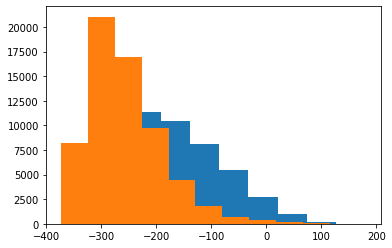

In [124]:
plt.hist(pred)
plt.hist(pred_live)

In [127]:
label_spoof = np.zeros(len(pred), dtype=np.int8)
label_live = np.ones(len(pred_live), dtype=np.int8)
labels = np.concatenate([label_spoof,label_live])

In [128]:
predictions = np.concatenate([pred, pred_live])

In [147]:
fpr, tpr, thresholds = roc_curve(labels,predictions, pos_label=0)

/home/cc/anaconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cc/anaconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  after removing the cwd from sys.path.


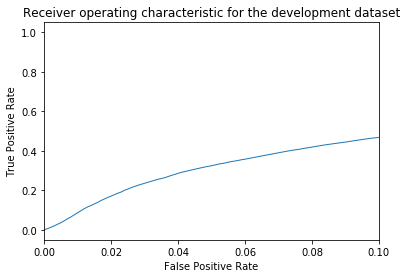

0.01320381216709863


In [150]:
from scipy import interp
mean_fpr = np.linspace(0, 1, 1000)  # point we want for fpr
tprs=interp(mean_fpr, fpr, tpr)
thrs=interp(mean_fpr, fpr, thresholds)
plt.plot(mean_fpr, tprs, lw=1, alpha=1)
plt.xlim([0, 0.1])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for the development dataset')
plt.show()
print(tprs[2])